# 2a_Baseline_7bcoder
## Notebook Overview: 

This notebook runs and evaluates the baseline model. 

In [ ]:
! pip install rouge_score
! pip install datasets
! pip install bert_score
! python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 25.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pprint
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

import json
import pprint
import pprint
# Import weights and biases
import wandb
# Import kaggle secrets
from google.colab import userdata

from tqdm import tqdm

In [ ]:
from evaluation_suite import EvaluationSuite

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/NLP/00_Data/train_dataset_balanced_shuffled.json', 'r') as f:
    trainset = json.load(f)

# Load test_dataset
with open('/content/drive/MyDrive/NLP/00_Data/test_dataset_balanced_shuffled.json', 'r') as f:
    testset = json.load(f)

In [ ]:
print("Trainsets:")
for split, split_data in trainset.items():
  print(f"{split}: {len(split_data)}")

print("\nTestsets:")
for split, split_data in testset.items():
  print(f"{split}: {len(split_data)}")

Trainsets:
true_false: 24281
multiple_choice: 70000
short_answer: 54060
multi_hop: 15763

Testsets:
true_false: 5971
multiple_choice: 20000
short_answer: 54060
multi_hop: 15763


In [ ]:
trainset = DatasetDict({
    split: Dataset.from_list(split_data)
    for split, split_data in trainset.items()
})

testset = DatasetDict({
    split: Dataset.from_list(split_data)
    for split, split_data in testset.items()
})

True: 523 (52.30%)
False: 477 (47.70%)


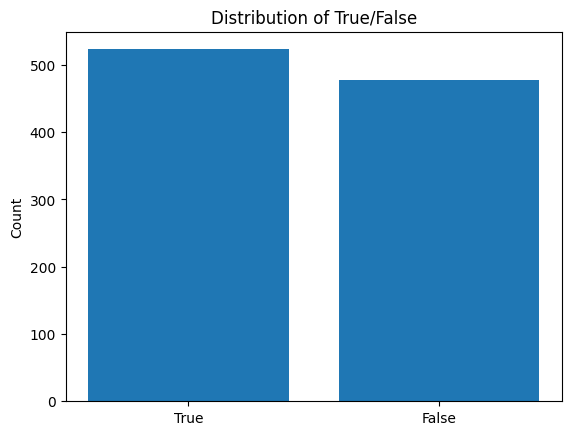

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example array
arr = np.array(tf_testset_dist[:1000])

# Count distribution
true_count = np.sum(arr)
false_count = len(arr) - true_count
total = len(arr)

# Calculate ratio
true_ratio = true_count / total
false_ratio = false_count / total

# Print results
print(f"True: {true_count} ({true_ratio:.2%})")
print(f"False: {false_count} ({false_ratio:.2%})")

# Optional: plot
labels = ['True', 'False']
counts = [true_count, false_count]

plt.bar(labels, counts)
plt.title("Distribution of True/False")
plt.ylabel("Count")
plt.show()

### Add model_input to each dataset

In [ ]:
def build_prompt(prompt_style: str, question: str):
  return prompt_style.replace("{_question_var_}", question)


def generate_model_input(example):

    if example['type'] == 'multiple_choice':
      prompt_style_multiple_choice = """
      "{_question_var_}"

      ### What is the correct answer? Please state only the letter:
      """
      question = example['question']
      options = example['options']

      model_input = question + '\nOptions:\n'
      for key, val in options.items():
          model_input += f"{key}. {val}\n"

      example['prompt'] = build_prompt(prompt_style_multiple_choice, model_input)
      example["answer"] = example.pop("correct_answer")
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    elif example['type'] == 'true_false':
      prompt_style_true_false = """
      "{_question_var_}"

      ### Is this statement true or false? Please state only False or True:
      """
      example['prompt'] = build_prompt(prompt_style_true_false, example['question'])
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    elif example['type'] == 'short_answer':
      prompt_style_short_answer = """
      "{_question_var_}"

      ### You are a medical expert and equipped to answer this specific question. Please answer:
      """
      example['prompt'] = build_prompt(prompt_style_short_answer, example['question'])
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    elif example['type'] == 'multi_hop':
      prompt_style_multi_hop = """
      "{_question_var_}"

      ### You are a medical expert and equipped to answer this specific question. Please answer the question and elaborate what steps you took:
      """
      example['prompt'] = build_prompt(prompt_style_multi_hop, example['question'])
      example['prompt_n_answer'] = example['prompt'] + example['answer']

    return example

In [ ]:
trainset = trainset.map(generate_model_input)
testset = testset.map(generate_model_input)

Map:   0%|          | 0/24281 [00:00<?, ? examples/s]

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/54060 [00:00<?, ? examples/s]

Map:   0%|          | 0/15763 [00:00<?, ? examples/s]

Map:   0%|          | 0/5971 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/54060 [00:00<?, ? examples/s]

Map:   0%|          | 0/15763 [00:00<?, ? examples/s]

# Load baseline model

In [ ]:
model_id = "deepseek-ai/deepseek-coder-7b-instruct-v1.5"  # or any other DeepSeek model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map="auto",
                                             torch_dtype=torch.float16)

tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

# Evaluation

In [ ]:
evaluation_suite = EvaluationSuite()

## Multiple Choice

In [ ]:
mc_testset = testset['multiple_choice']

In [ ]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
response = pipe(mc_testset[0]['prompt'])

Device set to use cuda:0


In [ ]:
predictions_multiple_choice = []

for i in tqdm(range(1000)):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(mc_testset[i]['prompt'],
                  max_new_tokens=20,
                  temperature=0.1,
                  top_p=0.9,
                  top_k=50,
                  do_sample=True
                  )

  predictions_multiple_choice.append(response)

100%|██████████| 1000/1000 [19:20<00:00,  1.16s/it]


In [ ]:
import re
predicted_answer_multiple_choice = []
for sample in predictions_multiple_choice:
  match = re.search(r'Please state only the letter:\s*\n*([A-E])\.*', sample[0].get('generated_text'))
  if match:
      answer = match.group(1)
      predicted_answer_multiple_choice.append(answer)
  else:
      predicted_answer_multiple_choice.append("na")

ground_truth = [entry['answer'] for entry in mc_testset.to_list()[:1000]]

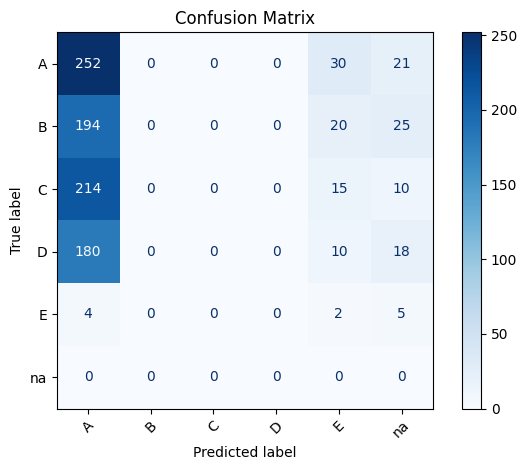

{'accuracy': 0.254,
 'precision': 0.05409203750435978,
 'recall': 0.1689168916891689}

In [ ]:
evaluation_suite.evaluate_discrete_answers(predicted_answer_multiple_choice, ground_truth, experiment_name="BASE_7bcoder_MC_1000")

## True False

In [ ]:
tf_testset = testset['true_false']
tf_testset = tf_testset.shuffle(seed=42)

In [ ]:
predictions_tf = []

for i in tqdm(range(1000)):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(tf_testset[i]['prompt'],
                  max_new_tokens=20,
                  temperature=0.1,
                  top_p=0.9,
                  top_k=50,
                  do_sample=True
                  )

  predictions_tf.append(response)

100%|██████████| 1000/1000 [19:02<00:00,  1.14s/it]


In [ ]:
predicted_answer_true_false = []
for sample in predictions_tf:
  match = re.search(r'Please state only False or True:\s*\n*(True|False)\.*', sample[0].get('generated_text'), re.IGNORECASE)
  if match:
      answer = match.group(1)
      predicted_answer_true_false.append({"predicted_answer": answer})
  else:
      predicted_answer_true_false.append({"predicted_answer": "na"})

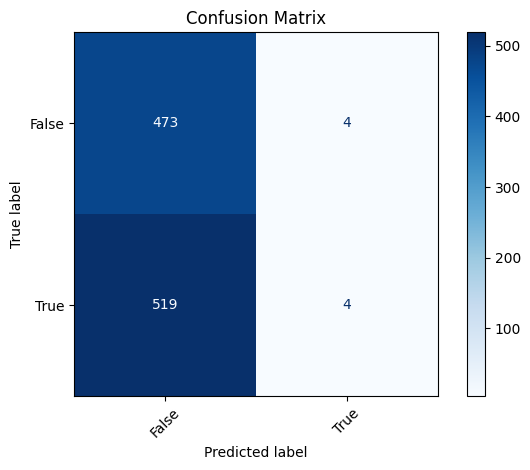

{'accuracy': 0.477,
 'precision': 0.4884072580645161,
 'recall': 0.49963121966080226}

In [ ]:
# Extract predicted and correct answers
y_pred_true_false = [entry['predicted_answer'] for entry in predicted_answer_true_false]
y_true_true_false = [entry['answer'] for entry in tf_testset.to_list()[:1000]]

evaluation_suite.evaluate_discrete_answers(y_pred_true_false, y_true_true_false, experiment_name="BASE_7bcoder_TF_1000")

## Short Answer

In [ ]:
sa_testset = testset['short_answer']


In [ ]:
predictions_sa = []

for i in tqdm(range(500)):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(sa_testset[i]['prompt'],
                  max_new_tokens=100,
                  temperature=0.7,
                  top_p=0.9,
                  top_k=50,
                  do_sample=True,
                  )

  predictions_sa.append(response)

100%|██████████| 500/500 [35:06<00:00,  4.21s/it]


In [ ]:
predicted_answer_short_answer = []
blocked_answers = 0
for sample in predictions_sa:
  match = re.search(
      r'### You are a medical expert and equipped to answer this specific question. Please answer:\s*(.+)',
      sample[0].get('generated_text'),
      re.DOTALL
  )
  if match:
      answer = match.group(1).strip()
      if answer.lower().startswith("i'm sorry, but"):
        answer = "N/A"
        blocked_answers += 1
      predicted_answer_short_answer.append({"predicted_answer": answer})
  else:
      predicted_answer_short_answer.append({"predicted_answer": "na"})

In [ ]:
ground_truth_sa = [entry['answer'] for entry in sa_testset.to_list()[:500]]
predicted_answer_short_answer = [entry['predicted_answer'] for entry in predicted_answer_short_answer]

In [ ]:
print(predicted_answer_short_answer)

["Eosinophilic fasciitis is a rare disease characterized by the infiltration of eosinophils into various parts of the body. The exact cause of Eosinophilic fasciitis is unknown, but it is often associated with allergies, asthma, and other immune system disorders.\n\nHowever, it's important to note that this is a medical question and not a computer science question. As an AI developed by Deepseek, I'm specialized in answering questions related to computer", 'N/A', 'Polycythemia is a condition characterized by an increase in the number of red blood cells in the body. This condition is also known as increased red cell count or normocytic normochromic hypercythemia. It is often associated with other conditions such as chronic kidney disease, anemia, and hypertension.\n\nPolycythemia can be classified into two types: secondary and primary. Secondary polycythemia is a result of underlying conditions like kidney disease, anemia,', 'Cardiac amyloidosis is a condition where a protein called amy

In [ ]:
evaluation_suite.evaluate_string_answers(predicted_answer_short_answer, ground_truth_sa, experiment_name="BASE_7bcoder_SA_500", return_individual=False)

rouge_scores [{'rouge1': 0.3870967741935484, 'rouge2': 0.11475409836065574, 'rougeL': 0.22580645161290322}, 0, {'rouge1': 0.01639344262295082, 'rouge2': 0.0, 'rougeL': 0.01639344262295082}, {'rouge1': 0.39062499999999994, 'rouge2': 0.20634920634920637, 'rougeL': 0.32812500000000006}, {'rouge1': 0.2626262626262626, 'rouge2': 0.10847457627118642, 'rougeL': 0.16835016835016836}, 0, {'rouge1': 0.012820512820512824, 'rouge2': 0.0, 'rougeL': 0.012820512820512824}, {'rouge1': 0.31764705882352945, 'rouge2': 0.10714285714285714, 'rougeL': 0.23529411764705882}, 0, {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, 0, {'rouge1': 0.08695652173913042, 'rouge2': 0.0, 'rougeL': 0.08695652173913042}, {'rouge1': 0.34234234234234234, 'rouge2': 0.11009174311926606, 'rougeL': 0.27027027027027023}, {'rouge1': 0.375, 'rouge2': 0.12643678160919541, 'rougeL': 0.26136363636363635}, {'rouge1': 0.5445544554455446, 'rouge2': 0.36, 'rougeL': 0.36633663366336633}, {'rouge1': 0.31999999999999995, 'rouge2': 0.09090909090

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge_scores:  [{'rouge1': 0.3870967741935484, 'rouge2': 0.11475409836065574, 'rougeL': 0.22580645161290322}, 0, {'rouge1': 0.01639344262295082, 'rouge2': 0.0, 'rougeL': 0.01639344262295082}, {'rouge1': 0.39062499999999994, 'rouge2': 0.20634920634920637, 'rougeL': 0.32812500000000006}, {'rouge1': 0.2626262626262626, 'rouge2': 0.10847457627118642, 'rougeL': 0.16835016835016836}, 0, {'rouge1': 0.012820512820512824, 'rouge2': 0.0, 'rougeL': 0.012820512820512824}, {'rouge1': 0.31764705882352945, 'rouge2': 0.10714285714285714, 'rougeL': 0.23529411764705882}, 0, {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, 0, {'rouge1': 0.08695652173913042, 'rouge2': 0.0, 'rougeL': 0.08695652173913042}, {'rouge1': 0.34234234234234234, 'rouge2': 0.11009174311926606, 'rougeL': 0.27027027027027023}, {'rouge1': 0.375, 'rouge2': 0.12643678160919541, 'rougeL': 0.26136363636363635}, {'rouge1': 0.5445544554455446, 'rouge2': 0.36, 'rougeL': 0.36633663366336633}, {'rouge1': 0.31999999999999995, 'rouge2': 0.090909090

{'avg_bleu': 0.013566921093334804,
 'avg_meteor': 0.06068491501717179,
 'rouge1': 0.08443039638059012,
 'rouge2': 0.03260469526134465,
 'rougeL': 0.0613695595070577,
 'word_similarity': 0.261695221146741,
 'sentence_similarity': 0.23727248483561736,
 'paragraph_similarity': 0.261695221146741,
 'semantic_match_score': 0.2543684002534039,
 'precision': 0.7805252075195312,
 'recall': 0.7913456559181213,
 'f1': 0.7853663563728333,
 'avg_cosine_similarity': 0.261695221146741,
 'avg_reasoning_coherence': 0.1909985954959432}

## Multi Hop

In [ ]:
mh_testset = testset['multi_hop']

In [ ]:
predictions_mh = []

for i in tqdm(range(500)):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(mh_testset[i]['prompt'],
                  max_new_tokens=200,
                  temperature=0.7,
                  top_p=0.9,
                  top_k=50,
                  do_sample=True
                  )

  predictions_mh.append(response)

100%|██████████| 500/500 [58:36<00:00,  7.03s/it]


In [ ]:
predicted_answer_mh = []
blocked_answers = 0
for sample in predictions_mh:
  match = re.search(
      r'### You are a medical expert and equipped to answer this specific question. Please answer the question and elaborate what steps you took:\s*(.+)',
      sample[0].get('generated_text'),
      re.DOTALL
  )
  if match:
      answer = match.group(1).strip()
      if answer.lower().startswith("i'm sorry, but"):
        answer = "N/A"
        blocked_answers += 1
      predicted_answer_mh.append({"predicted_answer": answer})
  else:
      predicted_answer_mh.append({"predicted_answer": "na"})

In [ ]:
ground_truth_mh = [entry['answer'] for entry in mh_testset.to_list()[:500]]
predicted_answer_mh = [entry['predicted_answer'] for entry in predicted_answer_mh]

evaluation_suite.evaluate_string_answers(predicted_answer_mh, ground_truth_mh, experiment_name="BASE_7bcoder_MH_500")

rouge_scores [{'rouge1': 0.6305732484076434, 'rouge2': 0.30769230769230765, 'rougeL': 0.35668789808917195}, 0, {'rouge1': 0.016666666666666666, 'rouge2': 0.0, 'rougeL': 0.016666666666666666}, {'rouge1': 0.38610038610038605, 'rouge2': 0.11673151750972761, 'rougeL': 0.2162162162162162}, 0, {'rouge1': 0.025316455696202535, 'rouge2': 0.0, 'rougeL': 0.025316455696202535}, {'rouge1': 0.28085106382978725, 'rouge2': 0.02575107296137339, 'rougeL': 0.13617021276595745}, 0, {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, 0, {'rouge1': 0.016666666666666666, 'rouge2': 0.0, 'rougeL': 0.016666666666666666}, {'rouge1': 0.1258741258741259, 'rouge2': 0.014184397163120567, 'rougeL': 0.0839160839160839}, {'rouge1': 0.3846153846153846, 'rouge2': 0.0970873786407767, 'rougeL': 0.1923076923076923}, {'rouge1': 0.3524229074889868, 'rouge2': 0.12444444444444443, 'rougeL': 0.18502202643171806}, {'rouge1': 0.3967611336032389, 'rouge2': 0.0653061224489796, 'rougeL': 0.1700404858299595}, {'rouge1': 0.4226415094339623

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge_scores:  [{'rouge1': 0.6305732484076434, 'rouge2': 0.30769230769230765, 'rougeL': 0.35668789808917195}, 0, {'rouge1': 0.016666666666666666, 'rouge2': 0.0, 'rougeL': 0.016666666666666666}, {'rouge1': 0.38610038610038605, 'rouge2': 0.11673151750972761, 'rougeL': 0.2162162162162162}, 0, {'rouge1': 0.025316455696202535, 'rouge2': 0.0, 'rougeL': 0.025316455696202535}, {'rouge1': 0.28085106382978725, 'rouge2': 0.02575107296137339, 'rougeL': 0.13617021276595745}, 0, {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}, 0, {'rouge1': 0.016666666666666666, 'rouge2': 0.0, 'rougeL': 0.016666666666666666}, {'rouge1': 0.1258741258741259, 'rouge2': 0.014184397163120567, 'rougeL': 0.0839160839160839}, {'rouge1': 0.3846153846153846, 'rouge2': 0.0970873786407767, 'rougeL': 0.1923076923076923}, {'rouge1': 0.3524229074889868, 'rouge2': 0.12444444444444443, 'rougeL': 0.18502202643171806}, {'rouge1': 0.3967611336032389, 'rouge2': 0.0653061224489796, 'rougeL': 0.1700404858299595}, {'rouge1': 0.42264150943396

{'avg_bleu': 0.018163207639328445,
 'avg_meteor': 0.08608927568397534,
 'rouge1': 0.13095889336731642,
 'rouge2': 0.0398320518022367,
 'rougeL': 0.07683985917996951,
 'word_similarity': 0.3515040635134593,
 'sentence_similarity': 0.30558522178262876,
 'paragraph_similarity': 0.3515040635134593,
 'semantic_match_score': 0.33772841099421014,
 'precision': 0.795860230922699,
 'recall': 0.8125807046890259,
 'f1': 0.8039768934249878,
 'avg_cosine_similarity': 0.3515040635134593,
 'avg_reasoning_coherence': 0.2532040731528321}